In [26]:
import pandas as pd
import numpy as np
import itertools
from ast import literal_eval

In [27]:
#importar dataframe do WMS
loc_itens_path = 'Desktop/TCC/GERAL/df_itens_layout2_5_10_1_100.csv'
df_localizacoes = pd.read_csv(loc_itens_path)
#importar dataframe dos pedidos
ordens_de_compra_path = 'Desktop/TCC/GERAL/df_ordens_de_compra_100.csv'
df_lista_dos_pedidos = pd.read_csv(ordens_de_compra_path)

#Incluir coluna 'Coord' em orderlines


In [28]:
#Identificar itens da lista de pedidos
tam_lista_de_pedidos = len(df_lista_dos_pedidos)
lista_de_itens = list(df_lista_dos_pedidos.Item)

#listas para buscar coord. dos pedidos
ls_posicao_x=[]
ls_posicao_y=[]


#Incluir coluna 'Coord' na df_lista_dos_pedidos na ordem da lista de pedidos
for i in range(tam_lista_de_pedidos):
    buscar_item = lista_de_itens[i]
    for k in range(len(df_localizacoes)):
        if buscar_item == int(df_localizacoes[k:k+1].Cod_Item):
            ls_posicao_x.append(int(df_localizacoes[k:k+1].Coord_X))
            ls_posicao_y.append(int(df_localizacoes[k:k+1].Coord_Y))
ls=list(zip(ls_posicao_x,ls_posicao_y))   
df_lista_dos_pedidos = df_lista_dos_pedidos.assign(Coord = ls)


In [29]:

def mapeamento_da_lista_de_pedidos(df_lista_dos_pedidos, tamanho_de_onda):
  ## Já está ordenada *Não funcionou com TimeStamp
   
    ls_pedidos = []
    tamanho_lista_dos_pedidos=len(df_lista_dos_pedidos)
    
    # lista de ordens ordenadas cronologicamente
    for j in range(tamanho_lista_dos_pedidos+1):
        ls_pedidos.append(j)
        
    # Dictionnary for mapping
    dict_map = dict(zip(ls_pedidos, [i for i in range(1, tamanho_lista_dos_pedidos+1)]))
    # Order ID mapping
    df_lista_dos_pedidos['ID_do_Pedido'] = df_lista_dos_pedidos['Unnamed: 0'].map(dict_map)
    df_lista_dos_pedidos['ID_da_Onda'] = (df_lista_dos_pedidos.ID_do_Pedido%tamanho_de_onda == 0).shift(1).fillna(0).cumsum()
    # Counting number of Waves
    numero_de_onda = df_lista_dos_pedidos.ID_da_Onda.max() + 1
    

    return df_lista_dos_pedidos, numero_de_onda


In [30]:
# Getting storage locations to cover for a wave of orders

def listagem_das_localizacoes(df_lista_dos_pedidos, ID_Onda):

    # Filter by ID_Onda
    df = df_lista_dos_pedidos[df_lista_dos_pedidos.ID_da_Onda == ID_Onda]
    # Create coordinates listing
    lista_localizacoes = list(df['Coord'])
    lista_localizacoes.sort()
    # Get unique Unique coordinates
    lista_localizacoes = list(k for k,_ in itertools.groupby(lista_localizacoes))
    tamanho_lista_localizacoes = len(lista_localizacoes)

    return lista_localizacoes, tamanho_lista_localizacoes




In [31]:

# Calculate Picker Route Distance between two locations
def distancia_de_busca(ponto1, ponto2, y_limite_inferior, y_limite_superior):

    # Start Point
    x1, y1 = ponto1[0], ponto1[1]
    # End Point
    x2, y2 = ponto2[0], ponto2[1]
    # Distance x-axis
    distancia_x = abs(x2 - x1)
    # Distance y-axis
    if x1 == x2:
        distancia_y1 = abs(y2 - y1)
        distancia_y2 = distancia_y1
    else:
        distancia_y1 = (y_limite_superior - y1) + (y_limite_superior - y2)
        distancia_y2 = (y1 - y_limite_inferior) + (y2 - y_limite_inferior)
    # Minimum distance on y-axis 
    distancia_y = min(distancia_y1, distancia_y2)    
    # Total distance
    distancia = distancia_x + distancia_y

    return distancia


In [32]:
def proximo_ponto(ponto_inicial, lista_localizacoes, y_limite_inferior, y_limite_superior):

    # Distance to every next points candidate
    lista_distancias = [distancia_de_busca(ponto_inicial, i, y_limite_inferior, y_limite_superior) for i in lista_localizacoes]
    # Minimum Distance 
    distancia_seguinte = min(lista_distancias)
    # Location of minimum distance
    index_min = lista_distancias.index(min(lista_distancias))
    ponto_seguinte = lista_localizacoes[index_min] # Next location is the first location with distance = min (**)
    lista_localizacoes.remove(ponto_seguinte)      # Next location is removed from the list of candidates
    
    return lista_localizacoes, ponto_inicial, ponto_seguinte, distancia_seguinte

In [33]:
# Calculate total distance to cover for a list of locations
def criar_rota_de_coleta(ponto_de_origem, lista_localizacoes, y_limite_inferior, y_limite_superior):

    # Total distance variable
    distancia_da_onda = 0
    # Current location variable 
    ponto_inicial = ponto_de_origem
    # Store routes
    lista_do_caminho = []
    lista_do_caminho.append(ponto_inicial)
    
    while len(lista_localizacoes) > 0: # Looping until all locations are picked
        # Going to next location
        lista_localizacoes, ponto_inicial, ponto_seguinte, distancia_seguinte = proximo_ponto(ponto_inicial, lista_localizacoes, y_limite_inferior, y_limite_superior)
        # Update ponto_inicial 
        ponto_inicial = ponto_seguinte
        lista_do_caminho.append(ponto_inicial)
        # Update distance
        distancia_da_onda = distancia_da_onda + distancia_seguinte 

    # Final distance from last storage location to origin
    distancia_da_onda = distancia_da_onda + distancia_de_busca(ponto_inicial, ponto_de_origem, y_limite_inferior, y_limite_superior)
    lista_do_caminho.append(ponto_de_origem)
    
    return distancia_da_onda, lista_do_caminho


   Numero da Onda  Distancia da Rota         Caminho Percorrido  Pedidos/Onda
0               0                 12   [[0, 0], (2, 4), [0, 0]]             1
1               1                 38  [[0, 0], (10, 9), [0, 0]]             1
2               2                  6   [[0, 0], (2, 1), [0, 0]]             1
3               3                 16   [[0, 0], (2, 6), [0, 0]]             1
4               4                 20   [[0, 0], (2, 8), [0, 0]]             1


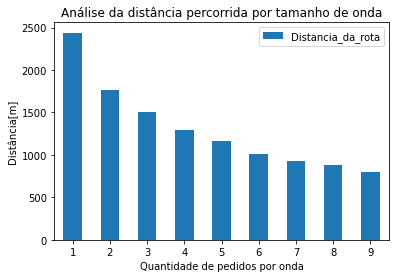

In [34]:
y_limite_inferior, y_limite_superior = 0, 11 		# Alley Coordinates on y-axis
ponto_de_origem = [0, y_limite_inferior]  			# Origin Location-->Ponto de expedição

#Create lists to store results
lista_id_da_onda, lista_da_distancia, lista_da_rota, lista_dos_pedidos = [], [], [], []

# Function 
def onda_simulada(y_limite_inferior, y_limite_superior, tamanho_de_onda, df_lista_dos_pedidos, lista_id_da_onda, lista_da_distancia, lista_da_rota, lista_dos_pedidos):

    # Create variable to store total distance
    distancia_da_rota = 0 
    # Create waves
    df_lista_dos_pedidos, numero_de_onda = mapeamento_da_lista_de_pedidos(df_lista_dos_pedidos, tamanho_de_onda)
    # Loop all waves
    for ID_Onda in range(numero_de_onda):
        # Listing of all locations for this wave 
        lista_localizacoes, tamanho_lista_localizacoes = listagem_das_localizacoes(df_lista_dos_pedidos, ID_Onda)
        # Results
        distancia_da_onda, lista_do_caminho = criar_rota_de_coleta(ponto_de_origem, lista_localizacoes, y_limite_inferior, y_limite_superior)
        distancia_da_rota = distancia_da_rota + distancia_da_onda
        # Append lists of results 
        lista_id_da_onda.append(ID_Onda)
        lista_da_distancia.append(distancia_da_onda)
        lista_da_rota.append(lista_do_caminho)
        lista_dos_pedidos.append(tamanho_de_onda)
        
    return lista_id_da_onda, lista_da_distancia, lista_da_rota, lista_dos_pedidos, distancia_da_rota
ls_rotas = []
ls_ordens = []
# Test several values of orders per wave
for tamanho_de_onda in range(1, 10):
    lista_id_da_onda, lista_da_distancia, lista_da_rota, lista_dos_pedidos, distancia_da_rota = onda_simulada(y_limite_inferior, y_limite_superior, tamanho_de_onda, df_lista_dos_pedidos, lista_id_da_onda, lista_da_distancia, lista_da_rota, lista_dos_pedidos)
    #print("Total distance covered for {} orders/wave: {:,} m".format(tamanho_de_onda, distancia_da_rota))
    ls_rotas.append(distancia_da_rota)
    ls_ordens.append(tamanho_de_onda)
# Create df for results
df_resultados = pd.DataFrame({'Numero da Onda': lista_id_da_onda,
               'Distancia da Rota': lista_da_distancia,
               'Caminho Percorrido': lista_da_rota,
               'Pedidos/Onda': lista_dos_pedidos})
print(df_resultados.head())
df_grafico = pd.DataFrame({'PedidosPorOnda':ls_ordens,
               'Distancia_da_rota':ls_rotas })
ax = df_grafico.plot.bar(x='PedidosPorOnda', y='Distancia_da_rota', rot=0, 
                         title= 'Análise da distância percorrida por tamanho de onda',
                        ylabel='Distância[m]',
                        xlabel='Quantidade de pedidos por onda')
df_grafico.to_excel("analise1_layout2REVISADO.xlsx")
df_resultados.to_excel("analise1detalhe_layout2REVISADO.xlsx")
